# Linear Regression Experiments
_Author: Emilio Luz-Ricca_

This notebook contains our (regularised) linear regression (ElasticNet) experiments across the four latitudes of interest (26.5N, 30S, 55S, 60S). Read section headings for more details on setup, preprocessing, and model training.

# Setup

Importing relevant modules and custom scripts. A number of helper functions are also defined to clean up experiment code.

In [52]:
import sys
import os
import pickle
import datetime

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# A wrapper class for stats models lin reg to facilitate sklearn grid search
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.1, L1_wt=0.1):
        self.alpha = alpha
        self.L1_wt = L1_wt
        self.model = None

    def fit(self, X, y):
        self.model = sm.OLS(y, X).fit_regularized(alpha=self.alpha, L1_wt=self.L1_wt)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [33]:
# A helper function to turn numeric latitudes to into strings
def format_lat(lat, with_degree = False):
    if with_degree:
        return str(-1 * lat) + '$\\mathbf{\\degree}$S' if lat < 0 else str(lat) + '$\\mathbf{\\degree}$N'
        
    return str(-1 * lat) + 'S' if lat < 0 else str(lat) + 'N'

In [4]:
# A helper function to subset 30S, since now the surface vars exist for all longitudes - values taken from basin function!
def mask_30S(inputs):
    mask = np.logical_or(np.logical_or(np.logical_and(inputs.longitude >= -180, 
                                                      inputs.longitude <= -71),
                                       np.logical_and(inputs.longitude >= 31, 
                                                      inputs.longitude <= 115)),
                         np.logical_and(inputs.longitude >= 153, 
                                        inputs.longitude <= 180))
    masked = inputs.where(mask, drop = True)

    return masked

In [5]:
# A helper function to add lags to the input dataset
def add_lags_inputs(inputs, num_months_lag):
    inputs = inputs.copy(deep = True)
    
    for field in inputs:
        for i in range(1, num_months_lag + 1):
            inputs[f'{field}_lag{i}'] = inputs[field].shift(time = i)

    return inputs

In [6]:
# A helper function to build filenames given the experiment variables
def build_filename(remove_trend, remove_season, num_months_lag, no_zonal_avgs, zonal_avgs):
    filename = ''

    if num_months_lag > 0 and len(no_zonal_avgs) > 0:
        raise ValueError('Non-zonal avg variables isn\'t implemented yet for time lags')
    if num_months_lag > 0:
        filename += f'{num_months_lag}month_time_lag_'
    else:
        filename += 'full_static_'

    if len(zonal_avgs) == 0 and len(no_zonal_avgs) == 0:
        raise ValueError('One of "zonal_avgs" or "no_zonal_avgs" must include variables!')
    if len(set(zonal_avgs).intersection(set(no_zonal_avgs))) != 0:
        raise ValueError('"zonal_avgs" and "no_zonal_avgs" cannot share any variables!')
    
    if len(no_zonal_avgs) > 0:
        filename += 'full_zonal' + f'({'+'.join(no_zonal_avgs)})_'
    if len(zonal_avgs) > 0:
        filename += 'zonal_avgs' + f'({'+'.join(zonal_avgs)})_'

    if remove_trend:
        filename += 'detrend_'
    else:
        filename += 'trend_'

    if remove_trend:
        filename += 'deseason'
    else:
        filename += 'season'

    return filename

# Experiment Variables

All variables that might be worth changing during experiments. Of particular interest is `no_zonal_averages` and `zonal_avgs` which controls which variables are averaged zonally and which variables are left with all longitudinal information.

In [11]:
# CONSTANTS
data_home = '/Users/emiliolr/Google Drive/My Drive/GTC'
lats = [26, -30, -55, -60]

# CHANGE BASED ON EXPERIMENT
remove_season = False
remove_trend = False

num_months_lag = 0

no_zonal_avgs = ['OBP']
zonal_avgs = ['ZWS']

filename = build_filename(remove_trend, remove_season, num_months_lag, no_zonal_avgs, zonal_avgs)
print(filename)

base_path = f'/Users/emiliolr/Desktop/regression_results/{filename}'
if os.path.exists(base_path):
    raise Exception('base_path already exists, please delete folder to run experiment')
os.mkdir(base_path)

# MISCELLANEOUS
verbose = True
mape_thresh = 0.5
cross_val_folds = 4
param_grid_levels = 4
train_pct = 0.7
results_dict = {}

full_static_full_zonal(OBP)_zonal_avgs(ZWS)_trend_season


# Running Experiments

Data is extracted and preprocessed as defined in the "Experiment Variables" section. Grid search with cross-validation is performed to find the best regularization weights for ElasticNet (`alpha` and `L1_wt`); see the [`statsmodels` documentation](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html#statsmodels.regression.linear_model.OLS.fit_regularized) for more details. Our five metrics (RMSE, MAE, MAPE, $R^2$, correlation) are then calculated and saved to a text file, and two helpul plots are saved as well.

In [12]:
# Looping through each latitude, prepping data, hyperparam tuning, and saving the results
for lat in lats:
    lat_str = format_lat(lat)
    filename_lat = f'{lat_str}_{filename}'
    print(f'Training on {lat_str}...')
    print()
    
    # Load in predictor vars
    inputs = xr.open_dataset(f'{data_home}/ecco_data_minimal/{lat_str}.nc')

    #  fixing longitude bounds of 30S
    if lat == -30:
        inputs = mask_30S(inputs)
    
    inputs = inputs.isel(latitude = 1) # pull out just the lat of interest
    inputs = inputs.expand_dims({'latitude' : 1}) # add back in latitude dim to make things work better

    #  fixing interior null values for 55S
    if lat == -55:
        inputs = inputs.dropna('longitude', how = 'all')

    # Load in response var
    outputs_fp = f'{data_home}/ecco_data_minimal/{lat_str}_moc_density.pickle'

    with open(outputs_fp, 'rb') as f:
        outputs = pickle.load(f)
    
    outputs = np.expand_dims(outputs, 1) 
    outputs = xr.Dataset(data_vars = {'moc' : (['time', 'latitude'], outputs)}, 
                         coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(lat)})

    # Preprocessing all inputs
    pp_data = apply_preprocessing(inputs,
                                  mode = 'inputs',
                                  remove_season = remove_season,
                                  remove_trend = remove_trend,
                                  standardize = True,
                                  lowpass = False,
                                  train_pct = train_pct)
    
    #  adding time lags for inputs 
    pp_data = add_lags_inputs(pp_data, num_months_lag)
    pp_data = pp_data.dropna('time', how = 'any') # removing timesteps at beginning w/no lags

    #  reshape inputs as desired, take zonal averages, and convert to a numpy array
    all_data_vars = list(pp_data.keys())
    pp_data_np_avg = np.empty((len(inputs.time), 0))
    pp_data_np_full = np.empty((len(inputs.time), 0))
    
    if len(zonal_avgs) > 0:
        print('ZONAL AVGS:')
        pp_data_np_avg = reshape_inputs(pp_data, keep_coords = ['time'], 
                                        data_vars = zonal_avgs if num_months_lag == 0 else all_data_vars)
        print()
    if len(no_zonal_avgs) > 0:
        print('NO ZONAL AVGS:')
        pp_data_np_full = pp_data[no_zonal_avgs].to_array().transpose('time', ...).squeeze().values 
        pp_data_np_full = pp_data_np_full.reshape(pp_data_np_full.shape[0], -1)

        print("axes: ['time', 'feature']")
        print(f'variables: {no_zonal_avgs}')
        print(f'shape: {pp_data_np_full.shape}')
        print()

    #  combine all inputs
    pp_data_np = np.concatenate((pp_data_np_avg, pp_data_np_full), axis = 1) if num_months_lag == 0 else pp_data_np_avg

    print(f'final shape: {pp_data_np.shape}')
    
    #  MOC strength from data
    strength = apply_preprocessing(outputs,
                                   mode = 'outputs',
                                   remove_season = remove_season,
                                   remove_trend = remove_trend,
                                   standardize = False,
                                   lowpass = False,
                                   train_pct = train_pct)
    strength_np = strength.moc.squeeze().values
    strength_np = strength_np[num_months_lag : ] # truncate the timeseries to match the lagged inputs
    
    X = pp_data_np
    y = strength_np

    #  adding a intercept - ones in the first column
    X = sm.add_constant(X)

    #  train/val/test split - no shuffling to ensure that the first 70% of timeseries is train and the last 30% is test!
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_pct, shuffle = False, 
                                                        stratify = None, random_state = 123456)
    
    # Define the hyperparameters to optimize over
    param_grid = {
        'alpha' : np.logspace(-4, 4, param_grid_levels),
        'L1_wt' : np.linspace(0, 1, param_grid_levels)
    }
    
    # TRAINING: grid search with cross-validation
    grid_search = GridSearchCV(SMWrapper(), param_grid, cv = cross_val_folds, 
                               scoring = 'neg_mean_squared_error', verbose = verbose)
    grid_search.fit(X_train, y_train)
    
    #  report best result
    if verbose:
        print(f'Best MSE (cross-validation): {round(-grid_search.best_score_, 3)}')
    
    #  calculate test performance and optionally report
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    metric_dict = {}
    metric_dict['R^2'] = round(r2_score(y_test, y_pred), 3)
    metric_dict['MSE'] = round(mean_squared_error(y_test, y_pred), 3)
    metric_dict['RMSE'] = round(root_mean_squared_error(y_test, y_pred), 3)
    metric_dict['MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
    metric_dict['MAPE'] = round(mean_absolute_percentage_error(y_test, y_pred) * 100, 3)

    #  calculating custom MAPE to ignore the smallest observed MOC values
    mape, num_discard = custom_MAPE(y_test, y_pred, threshold = mape_thresh, return_num_discarded = True)
    pct_kept = round((len(y_test) - num_discard) / len(y_test) * 100, 3)
    metric_dict['MAPE_thresh'] = f'{round(mape * 100, 3)} (thresh={mape_thresh}, {pct_kept}% kept)'

    if verbose:
        print(metric_dict)

    # Saving regression results to a text file for re-interpretation later
    txt_fp = f'{base_path}/{filename_lat}_RESULTS.txt'
    reg_results_txt(grid_search, txt_fp, zonal_avgs, no_zonal_avgs, metric_dict, save_weights = False)


    # Extracting all predictions in time order
    train_set_pred = grid_search.best_estimator_.predict(X_train)
    test_set_pred = grid_search.best_estimator_.predict(X_test)
    all_preds = np.concatenate([train_set_pred, test_set_pred])

    # Plotting results: timeseries
    time = pp_data.time.values
    fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
    
    plt_fp = f'{base_path}/{filename_lat}_TIMESERIES.png'
    plt.savefig(plt_fp, bbox_inches = 'tight')
    plt.close()

    # Plotting results: scatterplot
    fig, ax = pred_vs_actual(train_set_pred, test_set_pred, y_train, y_test)
    
    plt_fp = f'{base_path}/{filename_lat}_SCATTER.png'
    plt.savefig(plt_fp, bbox_inches = 'tight')
    plt.close()

    # Saving important values for later plotting
    results_dict[lat] = (all_preds, y, time, len(X_train))

    print('------')

Training on 26N...

ZONAL AVGS:
axes: ['time', 'feature']
variables: ['ZWS']
shape: (312, 1)

NO ZONAL AVGS:
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 164)

final shape: (312, 165)
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best MSE (cross-validation): 0.085
{'R^2': 0.985, 'MSE': 0.067, 'RMSE': 0.259, 'MAE': 0.204, 'MAPE': 43.679, 'MAPE_thresh': '16.827 (thresh=0.5, 79.787% kept)'}
------
Training on 30S...

ZONAL AVGS:
axes: ['time', 'feature']
variables: ['ZWS']
shape: (312, 1)

NO ZONAL AVGS:
axes: ['time', 'feature']
variables: ['OBP']
shape: (312, 440)

final shape: (312, 441)
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best MSE (cross-validation): 2.544
{'R^2': 0.947, 'MSE': 2.749, 'RMSE': 1.658, 'MAE': 1.291, 'MAPE': 9.957, 'MAPE_thresh': '9.957 (thresh=0.5, 100.0% kept)'}
------
Training on 55S...

ZONAL AVGS:
axes: ['time', 'feature']
variables: ['ZWS']
shape: (312, 1)

NO ZONAL AVGS:
axes: ['time', 'feature']
variables: ['OBP

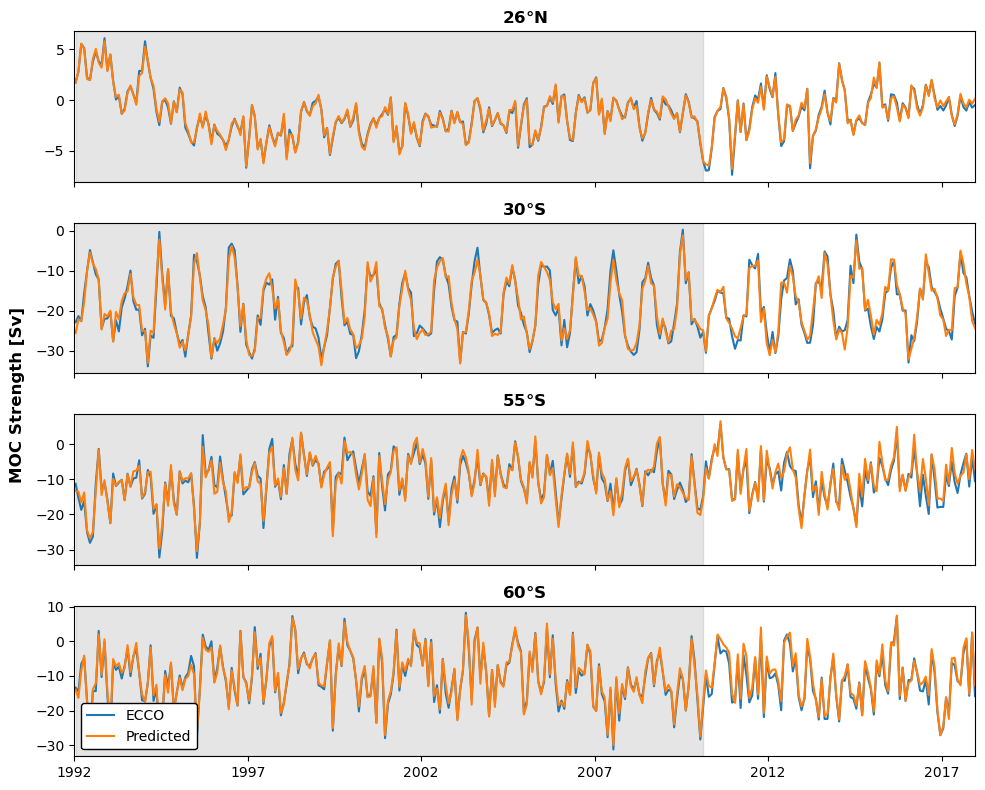

In [54]:
# Auxiliary plotting for use in the report - stacked timeseries plot
fig, ax = plt.subplots(len(lats), figsize = (10, 8), sharex = True)

for i, lat in enumerate(results_dict.keys()):
    pred, actual, time, len_xtrain = results_dict[lat]
    
    ax[i].plot(time, actual, label = 'ECCO')
    ax[i].plot(time, pred, label = 'Predicted')

    #  shading the train period
    y_lower, y_upper = ax[i].get_ylim()
    x_pos = time[ : len_xtrain]

    ax[i].fill_between(x = x_pos, 
                       y1 = np.repeat(y_lower, len(x_pos)), 
                       y2 = np.repeat(y_upper, len(x_pos)),
                       alpha = 0.2, 
                       color = 'gray')

    ax[i].margins(x = 0, y = 0)

    #  adding legend on only the bottom plot
    if i == len(lats) - 1: 
        ax[i].legend(loc = 'lower left', edgecolor = 'black', framealpha = 1)

    #  adding title
    ax[i].set_title(format_lat(lat, with_degree = True), weight = 'bold')

# Labeling the y-axis
fig.supylabel('MOC Strength [Sv]', weight = 'bold')

# Changing the xticks
plt.xticks(np.arange(str(time[0]).split('T')[0], '2019-01-16', 5, dtype = 'datetime64[Y]'))
myFmt = mdates.DateFormatter('%Y')
ax[-1].xaxis.set_major_formatter(myFmt)

# Spacing 
plt.tight_layout()

plt.savefig(f'{base_path}/stacked_lat_timeseries.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# Validating Best Results

This code is to validate the above experiments. Here, we only consider 60S with full zonal OBP, which consistently performed well in the trend/seasonality setting. Both `statsmodels` and `sklearn` ElasticNet regression models are fit using the best hyperparameter values to ensure the obtained results--which counterintuitively indicate that linear regression performs better than neural network models--are valid.

In [15]:
# Read in inputs
lat = '60S'
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{lat}.nc")

inputs = inputs.isel(latitude = 1) # pull out just 60S
inputs = inputs.expand_dims({'latitude' : 1}) # add back in latitude dim to make things work better
inputs = inputs.transpose('time', 'latitude', 'longitude')
inputs

<xarray.Dataset>
Dimensions:    (latitude: 1, time: 312, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -59.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 -0.9153 -0.9153 ... -0.851
    ZWS        (time, latitude, longitude) float32 0.09556 0.09556 ... 0.1381
    OBP        (time, latitude, longitude) float32 35.04 35.04 ... 37.31 37.31
    SSS        (time, latitude, longitude) float32 33.87 33.87 ... 33.92 33.92
    SST        (time, latitude, longitude) float32 5.382 5.382 ... 3.76 3.76

In [16]:
# Read in MOC timeseries
outputs_fp = f"{data_home}/ecco_data_minimal/{lat}_moc_density.pickle"

with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f)

outputs = np.expand_dims(outputs, 1) # grabbing just 60S
outputs = xr.Dataset(data_vars = {'moc' : (['time', 'latitude'], outputs)}, 
                     coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(-60)})
outputs

<xarray.Dataset>
Dimensions:   (time: 312, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) int64 -60
Data variables:
    moc       (time, latitude) float64 -13.38 -14.45 -6.522 ... 2.564 -15.85

In [17]:
# Apply standardization, not using preprocessing function
from sklearn.preprocessing import StandardScaler

obp = inputs.OBP.squeeze().values
moc_strength = outputs.moc.squeeze().values
X, y = obp, moc_strength

# Train/test split - manually or sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False, stratify = None)
# X_train, X_test = X[ : int(0.7 * len(X))], X[int(0.7 * len(X)) : ]
# y_train, y_test = y[ : int(0.7 * len(X))], y[int(0.7 * len(X)) : ]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_test = sm.add_constant(X_train), sm.add_constant(X_test)
print(X_train.shape, X_test.shape)

(218, 721) (94, 721)


In [18]:
from sklearn.linear_model import ElasticNet

# Best hyperparams from grid search
L1_wt = 1.0
alpha = 0.046415888336127774

# Fit ElasticNet to the data
sm_model = sm.OLS(y_train, X_train).fit_regularized(alpha = alpha, L1_wt = L1_wt)

# Trying sklearn ElasticNet implementation
sklearn_model = ElasticNet(alpha = alpha, l1_ratio = L1_wt, fit_intercept = False)
sklearn_model.fit(X_train, y_train);

In [22]:
# Evaluate on the test set
model = sm_model
y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print('R2:', r2)

RMSE: 1.698429157522962
MAE: 1.321868247632683
MAPE: 0.3587359818975497
R2: 0.945676448909587


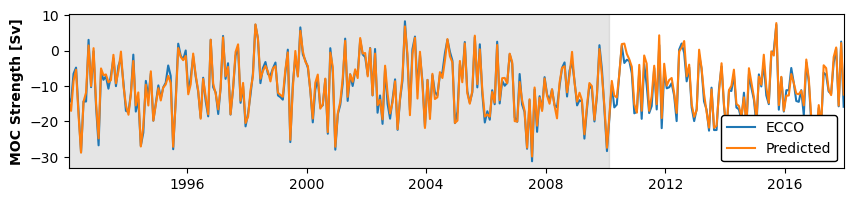

In [20]:
# Plotting for sanity check
all_preds = model.predict(np.concatenate((X_train, X_test), axis = 0))
time = outputs.time.values

fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
fig.set_size_inches((10, 2));